In [167]:
import torch
from torchvision import datasets, transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [168]:
# constants
BATCH_SIZE = 2048
target_mean = 0.5 # for normalizing image data
target_std = 0.5 # for normalizing image data
ENCODING_SIZE = 32

## Load data

In [169]:
initial_transform = transforms.Compose([transforms.ToTensor(),])
initial_dataset = datasets.MNIST(root='./data', train=True, transform=initial_transform, download=True)
initial_loader = torch.utils.data.DataLoader(initial_dataset, batch_size=len(initial_dataset))

In [170]:
data = next(iter(initial_loader))[0] # gets the entire dataset
current_mean = data.mean().item()
current_std = data.std().item()

In [171]:
print(f"{data.shape = }")
print(f"{current_mean = }")
print(f"{current_std = }")

data.shape = torch.Size([60000, 1, 28, 28])
current_mean = 0.13066047430038452
current_std = 0.30810782313346863


In [172]:
transform_mean = (current_mean * target_std - target_mean * current_std) / target_std
transform_std = current_std / target_std

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((transform_mean,), (transform_std,)),
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [173]:
# test statistics (make sure mean and median are 0.5 and 0.5)
statistics_test_loader = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
statistics_test_loader = torch.utils.data.DataLoader(statistics_test_loader, batch_size=len(statistics_test_loader))
data = next(iter(statistics_test_loader))[0] # gets the normalized entire dataset
current_mean = data.mean().item()
current_std = data.std().item()
print(f"{data.shape = }")
print(f"{current_mean = }") # confirm mean ~0.5
print(f"{current_std = }")  # confirm std  ~0.5

data.shape = torch.Size([60000, 1, 28, 28])
current_mean = 0.4999999701976776
current_std = 0.4999999701976776


## Training

In [174]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [278]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        mask_bottom = torch.zeros(32, requires_grad=False)
        mask_bottom[:16] = 1
        self.mask_bottom = mask_bottom
        
        mask_top = torch.zeros(32, requires_grad=False)
        mask_top[16:] = 1
        self.mask_top = mask_top
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, ENCODING_SIZE)
        )
        self.decoder = nn.Sequential(
            nn.Linear(ENCODING_SIZE, 512),
            nn.ReLU(),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=28*28, bias=False),
        )
        self.top_certificate = nn.Sequential(
            nn.Linear(ENCODING_SIZE//2, 512),
            nn.ReLU(),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=28*28, bias=False),
        )
        self.bottom_certificate = nn.Sequential(
            nn.Linear(ENCODING_SIZE//2, 512),
            nn.ReLU(),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=28*28, bias=False),
        )

    def forward(self, x, y):
        encoding = self.encoder(x)
        
        top_masks = y > 4
        bottom_masks = y < 4
        
        all_masks = torch.zeros(encoding.shape, requires_grad=False)
        all_masks[top_masks] = self.mask_top
        all_masks[bottom_masks] = self.mask_bottom
        all_masks = all_masks.to(device)
        
        encoding = all_masks * encoding + (1 - all_masks) * encoding.detach()
        
        top_cert = self.top_certificate(encoding.detach()[:,ENCODING_SIZE//2:])
        bottom_cert = self.bottom_certificate(encoding.detach()[:,ENCODING_SIZE//2:])
        logits = self.decoder(encoding)
        return encoding, logits, top_cert, bottom_cert

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=784, bias=False)
  )
  (top_certificate): Sequential(
    (0): Linear(in_features=16, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=784, bias=False)
  )
  (bottom_certificate): Sequential(
    (0): Linear(in_features=16, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_f

In [279]:
l1_loss = nn.L1Loss()
def loss_fn(X, X_hat, X_hat_top_cert, X_hat_bottom_cert, encoding, lambda_term=0.003, gamma=0.01):
    # Mean absolute error for reconstruction
    mae_top_cert = l1_loss(X, X_hat_top_cert)
    mae_bottom_cert = l1_loss(X, X_hat_bottom_cert)
    decoder_mae = l1_loss(X, X_hat)
    mae_reconstruction = decoder_mae + mae_top_cert + mae_bottom_cert
    
    # L1 norm for encoding
    encoding_loss = torch.norm(encoding, p=1) * lambda_term * (1/BATCH_SIZE)
    total_loss = mae_reconstruction + encoding_loss
    
    return decoder_mae, encoding_loss, mae_top_cert, mae_bottom_cert, total_loss

In [280]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-5)

In [281]:
def train(data_loader, loss, optimizer, model, epochs=1):
    model.train()
    train_loss_statistics = []
    decoder_maes = []
    encoding_losses = []
    mae_top_certs_loss = []
    mae_bottom_certs_loss = []
    
    for epoch in range(epochs):
        for batch_idx, data in enumerate(data_loader):
            X, y = data
            X = torch.flatten(X, start_dim=1).to(device)
            encoding, X_hat, X_hat_top_cert, X_hat_bottom_cert = model.forward(X, y)

            decoder_mae, encoding_loss, mae_top_cert, mae_bottom_cert, batch_loss = loss(X, X_hat, X_hat_top_cert, X_hat_bottom_cert, encoding)
            batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss_statistics.append(batch_loss.item())
            decoder_maes.append(decoder_mae.item())
            encoding_losses.append(encoding_loss.item())
            mae_top_certs_loss.append(mae_top_cert.item())
            mae_bottom_certs_loss.append(mae_bottom_cert.item())
            
            current_batch = len(data_loader)*epoch + batch_idx
            if current_batch % 1000 == 0:
                print(f"batch #{len(data_loader)*epoch + batch_idx}:\t {batch_loss:.4}")
                print(f"decoder:\t {decoder_mae:.4}")
                print(f"Top cert loss:\t {mae_top_cert:.4}")
                print(F"L1 loss:\t {encoding_loss:.4}")
                print("-------------------\n")
                
    return decoder_maes, encoding_losses, mae_top_certs_loss, mae_bottom_certs_loss, train_loss_statistics

In [282]:
train_rv = train(train_loader, loss_fn, optimizer, model, epochs=200)

batch #0:	 1.507
decoder:	 0.5008
Top cert loss:	 0.5001
L1 loss:	 0.00577
-------------------

batch #10:	 0.6833
decoder:	 0.2238
Top cert loss:	 0.2278
L1 loss:	 0.005586
-------------------

batch #20:	 0.6499
decoder:	 0.2141
Top cert loss:	 0.2163
L1 loss:	 0.00146
-------------------

batch #30:	 0.6357
decoder:	 0.211
Top cert loss:	 0.2118
L1 loss:	 0.0004865
-------------------

batch #40:	 0.6236
decoder:	 0.2071
Top cert loss:	 0.208
L1 loss:	 0.0001978
-------------------

batch #50:	 0.6235
decoder:	 0.2078
Top cert loss:	 0.2079
L1 loss:	 0.0001379
-------------------

batch #60:	 0.6128
decoder:	 0.2039
Top cert loss:	 0.2041
L1 loss:	 0.0001334
-------------------

batch #70:	 0.6244
decoder:	 0.2081
Top cert loss:	 0.2081
L1 loss:	 0.0001108
-------------------

batch #80:	 0.6189
decoder:	 0.2058
Top cert loss:	 0.2065
L1 loss:	 9.677e-05
-------------------

batch #90:	 0.6173
decoder:	 0.2051
Top cert loss:	 0.2059
L1 loss:	 0.0001118
-------------------

batch #10

batch #830:	 0.5442
decoder:	 0.1668
Top cert loss:	 0.1867
L1 loss:	 0.003534
-------------------

batch #840:	 0.5382
decoder:	 0.1646
Top cert loss:	 0.1846
L1 loss:	 0.003856
-------------------

batch #850:	 0.5438
decoder:	 0.166
Top cert loss:	 0.1868
L1 loss:	 0.003848
-------------------

batch #860:	 0.5409
decoder:	 0.1654
Top cert loss:	 0.1854
L1 loss:	 0.003863
-------------------

batch #870:	 0.5362
decoder:	 0.1643
Top cert loss:	 0.1834
L1 loss:	 0.003748
-------------------

batch #880:	 0.5311
decoder:	 0.164
Top cert loss:	 0.181
L1 loss:	 0.003737
-------------------

batch #890:	 0.5284
decoder:	 0.162
Top cert loss:	 0.1807
L1 loss:	 0.003618
-------------------

batch #900:	 0.53
decoder:	 0.1628
Top cert loss:	 0.1812
L1 loss:	 0.00378
-------------------

batch #910:	 0.5294
decoder:	 0.1629
Top cert loss:	 0.1808
L1 loss:	 0.003777
-------------------

batch #920:	 0.5218
decoder:	 0.1602
Top cert loss:	 0.1787
L1 loss:	 0.003822
-------------------

batch #

batch #1660:	 0.4324
decoder:	 0.1218
Top cert loss:	 0.1491
L1 loss:	 0.01207
-------------------

batch #1670:	 0.4244
decoder:	 0.12
Top cert loss:	 0.1462
L1 loss:	 0.01167
-------------------

batch #1680:	 0.4307
decoder:	 0.1203
Top cert loss:	 0.1495
L1 loss:	 0.01178
-------------------

batch #1690:	 0.4305
decoder:	 0.1217
Top cert loss:	 0.1484
L1 loss:	 0.0117
-------------------

batch #1700:	 0.4329
decoder:	 0.1223
Top cert loss:	 0.1494
L1 loss:	 0.01218
-------------------

batch #1710:	 0.4274
decoder:	 0.1209
Top cert loss:	 0.1464
L1 loss:	 0.01237
-------------------

batch #1720:	 0.4313
decoder:	 0.1206
Top cert loss:	 0.1497
L1 loss:	 0.01193
-------------------

batch #1730:	 0.4262
decoder:	 0.1196
Top cert loss:	 0.1477
L1 loss:	 0.01122
-------------------

batch #1740:	 0.4297
decoder:	 0.1201
Top cert loss:	 0.1485
L1 loss:	 0.01263
-------------------

batch #1750:	 0.4265
decoder:	 0.1192
Top cert loss:	 0.1478
L1 loss:	 0.01133
-------------------

bat

batch #2490:	 0.4188
decoder:	 0.1165
Top cert loss:	 0.1459
L1 loss:	 0.01115
-------------------

batch #2500:	 0.4097
decoder:	 0.1135
Top cert loss:	 0.1425
L1 loss:	 0.01031
-------------------

batch #2510:	 0.4156
decoder:	 0.1144
Top cert loss:	 0.1455
L1 loss:	 0.01056
-------------------

batch #2520:	 0.4116
decoder:	 0.113
Top cert loss:	 0.1442
L1 loss:	 0.01071
-------------------

batch #2530:	 0.414
decoder:	 0.1143
Top cert loss:	 0.1447
L1 loss:	 0.01051
-------------------

batch #2540:	 0.4094
decoder:	 0.1123
Top cert loss:	 0.1432
L1 loss:	 0.009984
-------------------

batch #2550:	 0.4078
decoder:	 0.1122
Top cert loss:	 0.1427
L1 loss:	 0.01044
-------------------

batch #2560:	 0.4163
decoder:	 0.115
Top cert loss:	 0.1446
L1 loss:	 0.01038
-------------------

batch #2570:	 0.4164
decoder:	 0.1152
Top cert loss:	 0.1453
L1 loss:	 0.01046
-------------------

batch #2580:	 0.4127
decoder:	 0.1144
Top cert loss:	 0.1437
L1 loss:	 0.01087
-------------------

ba

batch #3320:	 0.4129
decoder:	 0.1116
Top cert loss:	 0.145
L1 loss:	 0.01079
-------------------

batch #3330:	 0.4132
decoder:	 0.1114
Top cert loss:	 0.1462
L1 loss:	 0.01062
-------------------

batch #3340:	 0.4107
decoder:	 0.1113
Top cert loss:	 0.1449
L1 loss:	 0.01053
-------------------

batch #3350:	 0.4089
decoder:	 0.1106
Top cert loss:	 0.1439
L1 loss:	 0.01063
-------------------

batch #3360:	 0.4077
decoder:	 0.111
Top cert loss:	 0.1425
L1 loss:	 0.01102
-------------------

batch #3370:	 0.4102
decoder:	 0.1111
Top cert loss:	 0.1442
L1 loss:	 0.01096
-------------------

batch #3380:	 0.4185
decoder:	 0.1131
Top cert loss:	 0.1471
L1 loss:	 0.01107
-------------------

batch #3390:	 0.412
decoder:	 0.1111
Top cert loss:	 0.1447
L1 loss:	 0.01089
-------------------

batch #3400:	 0.409
decoder:	 0.1101
Top cert loss:	 0.144
L1 loss:	 0.01084
-------------------

batch #3410:	 0.4141
decoder:	 0.1127
Top cert loss:	 0.1452
L1 loss:	 0.0107
-------------------

batch 

batch #4150:	 0.413
decoder:	 0.1089
Top cert loss:	 0.1467
L1 loss:	 0.01164
-------------------

batch #4160:	 0.4147
decoder:	 0.1089
Top cert loss:	 0.1469
L1 loss:	 0.01215
-------------------

batch #4170:	 0.4103
decoder:	 0.1077
Top cert loss:	 0.1449
L1 loss:	 0.01258
-------------------

batch #4180:	 0.4224
decoder:	 0.1108
Top cert loss:	 0.1495
L1 loss:	 0.01303
-------------------

batch #4190:	 0.4169
decoder:	 0.1102
Top cert loss:	 0.1469
L1 loss:	 0.01301
-------------------

batch #4200:	 0.4234
decoder:	 0.1101
Top cert loss:	 0.1492
L1 loss:	 0.01421
-------------------

batch #4210:	 0.4262
decoder:	 0.1112
Top cert loss:	 0.1503
L1 loss:	 0.01343
-------------------

batch #4220:	 0.4157
decoder:	 0.1083
Top cert loss:	 0.1471
L1 loss:	 0.01279
-------------------

batch #4230:	 0.418
decoder:	 0.1094
Top cert loss:	 0.148
L1 loss:	 0.01279
-------------------

batch #4240:	 0.4257
decoder:	 0.1102
Top cert loss:	 0.1507
L1 loss:	 0.01305
-------------------

bat

batch #4980:	 0.4596
decoder:	 0.1153
Top cert loss:	 0.1575
L1 loss:	 0.02708
-------------------

batch #4990:	 0.4429
decoder:	 0.1123
Top cert loss:	 0.1542
L1 loss:	 0.02308
-------------------

batch #5000:	 0.4455
decoder:	 0.113
Top cert loss:	 0.1561
L1 loss:	 0.02192
-------------------

batch #5010:	 0.4423
decoder:	 0.1126
Top cert loss:	 0.1526
L1 loss:	 0.02303
-------------------

batch #5020:	 0.4562
decoder:	 0.1141
Top cert loss:	 0.1535
L1 loss:	 0.03433
-------------------

batch #5030:	 0.4801
decoder:	 0.1185
Top cert loss:	 0.1564
L1 loss:	 0.04955
-------------------

batch #5040:	 0.4726
decoder:	 0.118
Top cert loss:	 0.16
L1 loss:	 0.03511
-------------------

batch #5050:	 0.4379
decoder:	 0.1131
Top cert loss:	 0.155
L1 loss:	 0.01619
-------------------

batch #5060:	 0.4643
decoder:	 0.1166
Top cert loss:	 0.1565
L1 loss:	 0.03477
-------------------

batch #5070:	 0.5727
decoder:	 0.1316
Top cert loss:	 0.1876
L1 loss:	 0.08528
-------------------

batch

batch #5810:	 0.4387
decoder:	 0.1109
Top cert loss:	 0.1517
L1 loss:	 0.02456
-------------------

batch #5820:	 0.4317
decoder:	 0.1092
Top cert loss:	 0.1498
L1 loss:	 0.02314
-------------------

batch #5830:	 0.4373
decoder:	 0.1096
Top cert loss:	 0.1509
L1 loss:	 0.02618
-------------------

batch #5840:	 0.435
decoder:	 0.1091
Top cert loss:	 0.1505
L1 loss:	 0.02484
-------------------

batch #5850:	 0.4396
decoder:	 0.1104
Top cert loss:	 0.1506
L1 loss:	 0.02742
-------------------

batch #5860:	 0.4351
decoder:	 0.1093
Top cert loss:	 0.1498
L1 loss:	 0.02655
-------------------

batch #5870:	 0.4403
decoder:	 0.1104
Top cert loss:	 0.1505
L1 loss:	 0.02891
-------------------

batch #5880:	 0.4396
decoder:	 0.11
Top cert loss:	 0.151
L1 loss:	 0.02768
-------------------

batch #5890:	 0.446
decoder:	 0.1112
Top cert loss:	 0.1525
L1 loss:	 0.03021
-------------------

batch #5900:	 0.45
decoder:	 0.1109
Top cert loss:	 0.1519
L1 loss:	 0.03586
-------------------

batch #

In [286]:
decoder_maes, encoding_losses, mae_top_certs_loss, mae_bottom_certs_loss, train_loss_statistics = train_rv

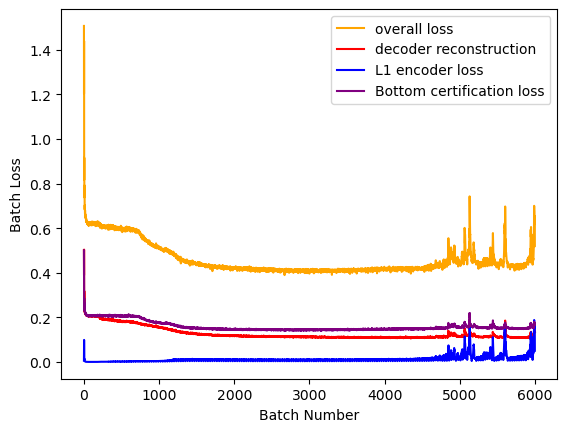

In [294]:
plt.plot(np.arange(0, len(train_loss_statistics)), train_loss_statistics, color='orange', label="overall loss")
plt.plot(np.arange(0, len(train_loss_statistics)), decoder_maes, color='red', label="decoder reconstruction")
plt.plot(np.arange(0, len(train_loss_statistics)), encoding_losses, color='blue', label="L1 encoder loss")
plt.plot(np.arange(0, len(train_loss_statistics)), mae_bottom_certs_loss, color='purple', label="Bottom certification loss")

plt.xlabel("Batch Number")
plt.ylabel("Batch Loss")
plt.legend()
plt.show()

## Testing Certificates

In [306]:
test_images_batch, test_labels_batch = next(iter(test_loader))

In [309]:
encoding, X_hat, X_hat_top_cert, X_hat_bottom_cert = model.forward(
    torch.flatten(test_images_batch, start_dim=1).to(device),
    test_labels_batch.to(device)
)

In [310]:
X_hat_top_cert.shape

torch.Size([2048, 784])

In [323]:
low_digits = torch.flatten(test_images_batch[test_labels_batch < 4,...], start_dim=1)
high_digits = torch.flatten(test_images_batch[test_labels_batch > 4,...], start_dim=1)
bottom_cert_low_digits = X_hat_top_cert[test_labels_batch < 4,:].to('cpu')
bottom_cert_high_digits = X_hat_top_cert[test_labels_batch > 4,:].to('cpu')
low_digits_loss = l1_loss(low_digits, bottom_cert_low_digits)
high_digits_loss = l1_loss(high_digits, bottom_cert_high_digits)

In [324]:
low_digits_loss, high_digits_loss

(tensor(0.1662, grad_fn=<MeanBackward0>),
 tensor(0.1569, grad_fn=<MeanBackward0>))

## Saving Model

In [304]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': 200,
    'loss': 0.06390269100666046
}, "200_epochs_with_certs/model.pth")

## Generating Image Samples

In [298]:
test_images_batch, test_labels_batch = next(iter(test_loader))

In [300]:
# get reconstructed images
_encodings, reconstructed_test_imgs, _top_cert, _bottom_cert = model.forward(torch.flatten(test_images_batch, start_dim=1).to(device),test_labels_batch.to(device))
reconstructed_test_imgs = reconstructed_test_imgs.view(-1, 28, 28)
reconstructed_test_imgs= reconstructed_test_imgs.cpu().detach()

In [301]:
_encodings.shape

torch.Size([2048, 32])

In [302]:
_encodings.sum(dim=0).shape

torch.Size([32])

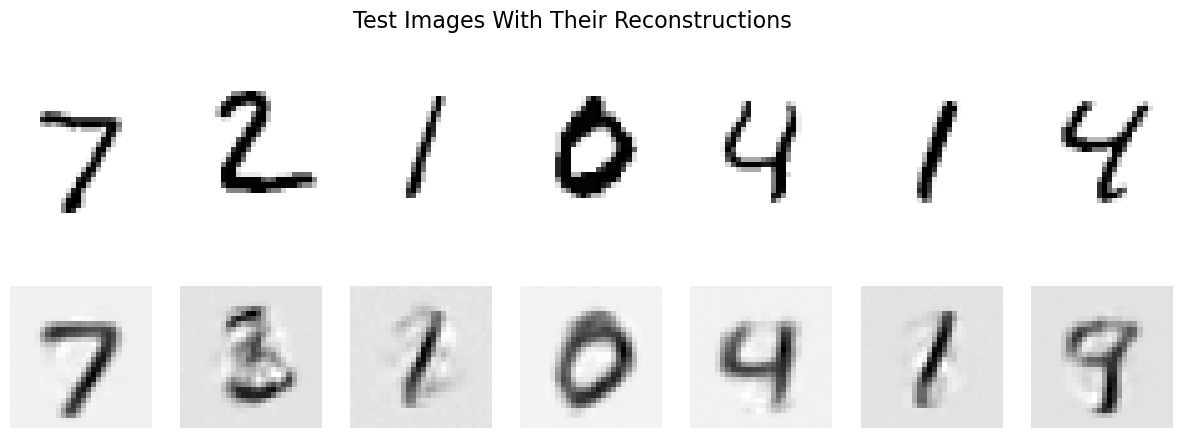

In [305]:
columns = 7
rows = 2
fig, axes = plt.subplots(rows, columns, figsize=(15, 5))
for i, ax in enumerate(axes.flat):
    if i >= columns:
        ax.imshow(reconstructed_test_imgs[i - columns]* -1, cmap='gray')
    else:
        ax.imshow(test_images_batch[i].squeeze()* -1, cmap='gray')
    ax.axis('off')
fig.suptitle('Test Images With Their Reconstructions', fontsize=16)
plt.savefig('200_epochs_with_certs/image_reconstructions.png', dpi=300)
plt.show()